# Forecasting with TFT: Temporal Fusion Transformer

Temporal Fusion Transformer (TFT) proposed by Lim et al. [1] is one of the most popular transformer-based model for time-series forecasting. In summary, TFT combines gating layers, an LSTM recurrent encoder, with multi-head attention layers for a multi-step forecasting strategy decoder. For more details on the Nixtla's TFT implementation visit [this link](https://nixtla.github.io/neuralforecast/models.tft.html).

In this notebook we show how to train the TFT model on the Texas electricity market load data (ERCOT). Accurately forecasting electricity markets is of great interest, as it is useful for planning distribution and consumption.

We will show you how to load the data, train the TFT performing automatic hyperparameter tuning, and produce forecasts. Then, we will show you how to perform multiple historical forecasts for cross validation.

You can run these experiments using GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/Forecasting_TFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Libraries

In [ ]:
%%capture
!pip install neuralforecast

In [ ]:
import torch
import numpy as np
import pandas as pd

In [ ]:
torch.cuda.is_available()

True

## 2. Load ERCOT Data

The input to NeuralForecast is always a data frame in [long format](https://www.theanalysisfactor.com/wide-and-long-data/) with three columns: `unique_id`, `ds` and `y`:

* The `unique_id` (string, int or category) represents an identifier for the series. 

* The `ds` (datestamp or int) column should be either an integer indexing time or a datestamp ideally like YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast. 
We will rename the 

First, read the 2022 historic total demand of the ERCOT market. We processed the original data (available [here](https://www.ercot.com/gridinfo/load/load_hist)), by adding the missing hour due to daylight saving time, parsing the date to datetime format, and filtering columns of interest.

In [ ]:
Y_df = pd.read_csv('https://datasets-nixtla.s3.amazonaws.com/ERCOT-clean.csv')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])
Y_df.head()

,unique_id,ds,y
0,ERCOT,2021-01-01 00:00:00,43719.849616
1,ERCOT,2021-01-01 01:00:00,43321.050347
2,ERCOT,2021-01-01 02:00:00,43063.067063
3,ERCOT,2021-01-01 03:00:00,43090.059203
4,ERCOT,2021-01-01 04:00:00,43486.590073


## 3. Model training and forecast

First, instantiate the `AutoTFT` model. The `AutoTFT` class will automatically perform hyperparamter tunning using [Tune library](https://docs.ray.io/en/latest/tune/index.html), exploring a user-defined or default search space. Models are selected based on the error on a validation set and the best model is then stored and used during inference. 

To instantiate `AutoTFT` you need to define:

* `h`: forecasting horizon
* `loss`: training loss
* `config`: hyperparameter search space. If `None`, the `AutoTFT` class will use a pre-defined suggested hyperparameter space.
* `num_samples`: number of configurations explored.

In [ ]:
from ray import tune

from neuralforecast.auto import AutoTFT
from neuralforecast.core import NeuralForecast
from neuralforecast.losses.pytorch import MAE

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

:::{.callout-tip}
Increase the `num_samples` parameter to explore a wider set of configurations for the selected models. As a rule of thumb choose it to be bigger than `15`.  

With `num_samples=3` this example should run in around 20 minutes.
:::

In [ ]:
horizon = 24
models = [AutoTFT(h=horizon,
                  loss=MAE(),
                  config=None,
                  num_samples=3)]

:::{.callout-tip}
All our models can be used for both point and probabilistic forecasting. For producing probabilistic outputs, simply modify the loss to one of our `DistributionLoss`. The complete list of losses is available in [this link](https://nixtla.github.io/neuralforecast/losses.pytorch.html) 
:::

::: {.callout-important collapse="true"}

TFT is a very large model and can require a lot of memory! If you are running out of GPU memory, try declaring your config search space and decrease the `hidden_size`, `n_heads`, and `windows_batch_size` parameters.

This are all the parameters of the config: 

```python
config = {
      "input_size": tune.choice([horizon]),
      "hidden_size": tune.choice([32]),
      "n_head": tune.choice([2]),
      "learning_rate": tune.loguniform(1e-4, 1e-1),
      "scaler_type": tune.choice(['robust', 'standard']),
      "max_steps": tune.choice([500, 1000]),
      "windows_batch_size": tune.choice([32]),
      "check_val_every_n_epoch": tune.choice([100]),
      "random_seed": tune.randint(1, 20),
}
```
:::

The `NeuralForecast` class has built-in methods to simplify the forecasting pipelines, such as `fit`, `predit`, and `cross_validation`. Instantiate a `NeuralForecast` object with the following required parameters:

* `models`: a list of models.

* `freq`: a string indicating the frequency of the data. (See [panda's available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

Then, use the `fit` method to train the `AutoTFT` model on the ERCOT data. The total training time will depend on the hardware and the explored configurations, it should take between 10 and 30 minutes.

In [ ]:
%%capture
nf = NeuralForecast(
    models=models,
    freq='H')

nf.fit(df=Y_df)

Finally, use the `predict` method to forecast the next 24 hours after the training data and plot the forecasts.

In [ ]:
Y_hat_df = nf.predict()
Y_hat_df.head()

Predicting: 0it [00:00, ?it/s]

,ds,AutoTFT
unique_id,,
ERCOT,2022-10-01 00:00:00,38644.019531
ERCOT,2022-10-01 01:00:00,36833.121094
ERCOT,2022-10-01 02:00:00,35698.265625
ERCOT,2022-10-01 03:00:00,35065.148438
ERCOT,2022-10-01 04:00:00,34788.566406


Plot the results with matplot lib

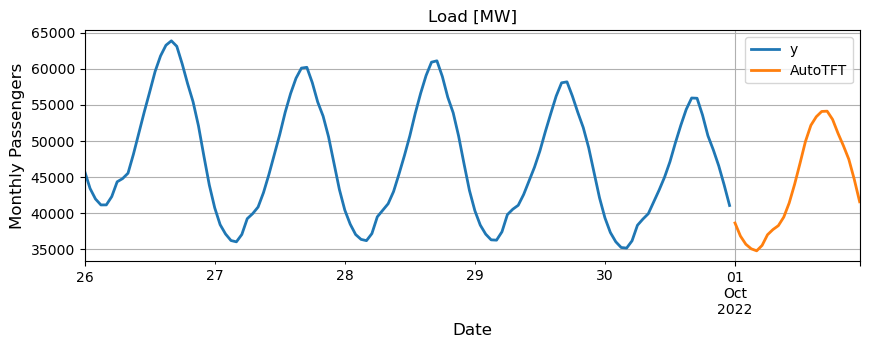

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize = (10, 3))
plot_df = pd.concat([Y_df.tail(24*5).reset_index(drop=True), Y_hat_df]).set_index('ds') # Concatenate the train and forecast dataframes
plot_df[['y', 'AutoTFT']].plot(ax=ax, linewidth=2)

ax.set_title('Load [MW]', fontsize=12)
ax.set_ylabel('Monthly Passengers', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.legend(prop={'size': 10})
ax.grid()

## 4. Cross validation for multiple historic forecasts

The `cross_validation` method allows you to simulate multiple historic forecasts, greatly simplifying pipelines by replacing for loops with `fit` and `predict` methods. See [this tutorial](https://nixtla.github.io/statsforecast/examples/getting_started_complete.html) for an animation of how the windows are defined. 

With time series data, cross validation is done by defining a sliding window across the historical data and predicting the period following it. This form of cross validation allows us to arrive at a better estimation of our model’s predictive abilities across a wider range of temporal instances while also keeping the data in the training set contiguous as is required by our models. The `cross_validation` method will use the validation set for hyperparameter selection, and will then produce the forecasts for the test set.

Use the `cross_validation` method to produce all the daily forecasts for September. Set the validation and test sizes. To produce daily forecasts set the forecasting set the step size between windows as 24, to only produce one forecast per day.

In [ ]:
%%capture
val_size  = 90*24 # 90 days x 24 hours
test_size = 30*24 # 30 days x 24 hours
fcst_df = nf.cross_validation(df=Y_df, val_size=val_size, test_size=test_size,
                                n_windows=None, step_size=horizon)

Finally, we merge the forecasts with the `Y_df` dataset and plot the forecasts.

In [ ]:
Y_hat_df = fcst_df.reset_index(drop=True)
Y_hat_df = Y_hat_df.drop(columns=['y','cutoff'])

[]

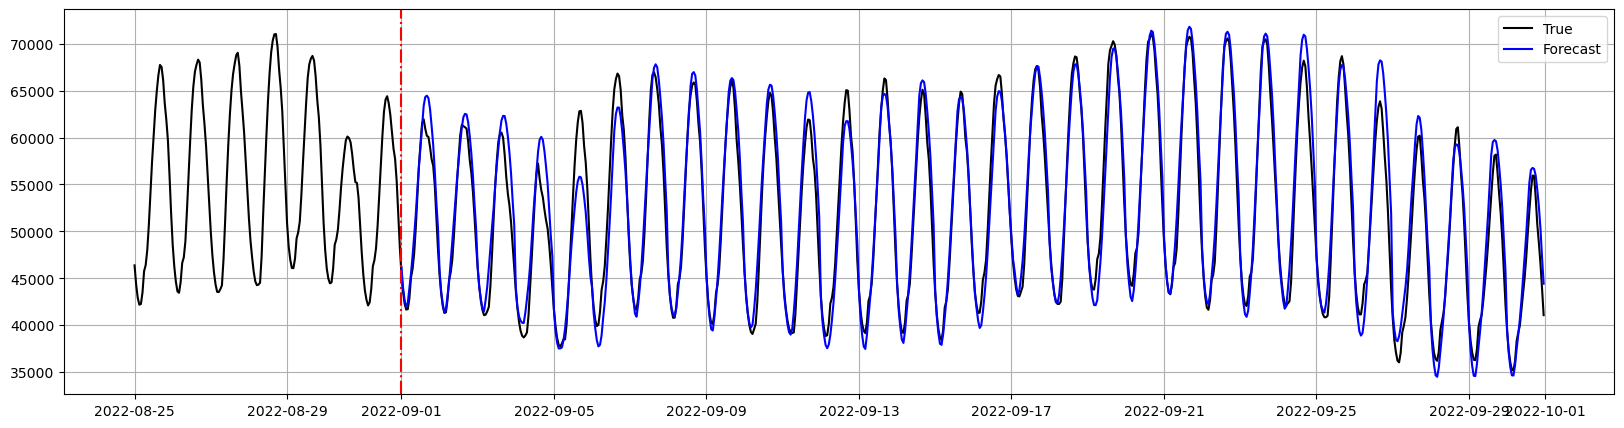

In [ ]:
plot_df = Y_df.merge(Y_hat_df, on=['unique_id','ds'], how='outer').tail(test_size+24*7)

plt.figure(figsize=(20,5))
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['AutoTFT'], c='blue', label='Forecast')
plt.axvline(pd.to_datetime('2022-09-01'), color='red', linestyle='-.')
plt.legend()
plt.grid()
plt.plot()

## Next Steps

In Challu et al [2] we demonstrate that the N-HiTS model outperforms the latest transformers by more than 20% with 50 times less computation.

Learn how to use the N-HiTS and the NeuralForecast library in [this tutorial](https://nixtla.github.io/neuralforecast/examples/electricitypeakforecasting.html).

## References

[1] [Lim, B., Arık, S. Ö., Loeff, N., & Pfister, T. (2021). Temporal fusion transformers for interpretable multi-horizon time series forecasting. International Journal of Forecasting, 37(4), 1748-1764.](https://www.sciencedirect.com/science/article/pii/S0169207021000637).

[2] [Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, Max Mergenthaler-Canseco, Artur Dubrawski (2021). N-HiTS: Neural Hierarchical Interpolation for Time Series Forecasting. Accepted at AAAI 2023.](https://arxiv.org/abs/2201.12886)